 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

# Recollision Probability Theory

A useful source of information quantifying vegetation amount is the Leaf Area Index (LAI). To interpret LAI from satellite data, we build models of radiative transfer.

One of the simplest such models that we can use at optical wavelengths uses what is known as 'p theory' or 'recollision probability theory' (Lewis and Disney, 2007; Huang et al., 2007).

**The task today is to use p-theory to estimate LAI over some agricultural fields.**

References

* P. Lewis and M. Disney (2007) Spectral invariants and scattering across multiple scales from within-leaf to canopy, [Remote Sensing of Environment 109, 196-206.](http://www2.geog.ucl.ac.uk/~mdisney/papers/lewis_disney_prospect.pdf)
* D. Huang, Y. Knyazikhin, R.E. Dickinson, M. Rautiainen, P. Stenberg, M. Disney, P. Lewis, A. Cescatti, Y. Tian, W. Verhoef, and R.B. Myneni (2007), Canopy spectral invariants for remote sensing and model applications, [Remote Sensing of Environment, 106, 106-122](http://www2.geog.ucl.ac.uk/~plewis/Huang_Spectral_Revised.pdf)
* Knyazikhin Y, Schull MA, Stenberg P, Mottus M, Rautiainen M, Yang Y, Marshak A, Latorre Carmona P, Kaufmann RK, Lewis P, Disney MI, Vanderbilt V, Davis AB, Baret F, Jacquemoud S, Lyapustin A, Myneni RB. (2013) Hyperspectral remote sensing of foliar nitrogen content. Proc Natl Acad Sci USA, [10.1073/pnas.1210196109](http://cybele.bu.edu/download/manuscripts/knyazikhin-pnas-hypspec.pdf).

# Data

The dataset you have available is an airborne hyperspectral image (HYMAP) dataset for which you have a 512x512 pixel subscene taken in 125 wavebands with a spatial resolution of 4m. The data were obtained on 17 June 2000 over Barton Bendish Farms, Norfolk during the BNSC/NERC SHAC campaign.

The data are available as a compressed *flat binary* file in the directory [`files/data`](files/data).

First, uncompress the dataset:

In [7]:
# or try zcat if gzcat isnt there
!gzcat files/data/bbHYMAP.dat.gz > files/data/bbHYMAP.dat

In [8]:
!ls -l files/data/bbHYMAP.dat

-rw-r--r--  1 plewis  staff  131072000 26 Nov 17:31 files/data/bbHYMAP.dat


The file is 131072000 bytes in 32 bit floating point format:

In [10]:
print 'nbands =',131072000/(512*512*4)

nbands = 125


In [14]:
# we wuill use memmap to read the data in
from numpy import memmap

In [16]:
hymap = memmap('files/data/bbHYMAP.dat',dtype=np.float32,mode='r',shape=(125,512,512))

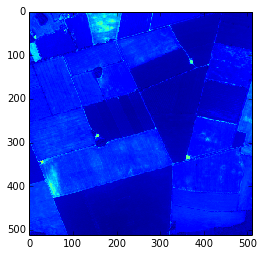

In [17]:
plt.imshow(hymap[10],interpolation='nearest')

The wavelengths associated with each band are stored in [`files/data/wavebands.dat`](files/data/wavebands.dat).

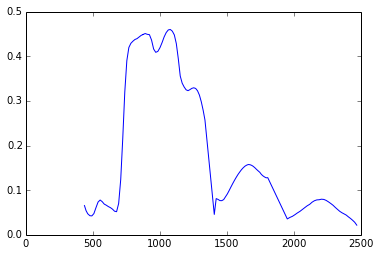

In [22]:
mean = hymap.mean(axis=(1,2))
wavelength = np.loadtxt('files/data/wavebands.dat')
plt.plot(wavelength,mean)

# Theory

The simplest form of model in p-theory assumes that the photon recollision probability is constant with wavelength and scattering order. Under this assumption, the total scattering from the canopy, $W$ is:

$$
W = i_0 \frac{(1 - p) \omega}{1 - p \omega}
$$

where $i_0$ is the canopy interception probability, $\omega$ is the leaf-level scattering (the leaf single scattering albedo) and $p$ is the recollision probability: the probability that a photon, having intercepted a canopy element, will recollide with another element rather than escape the canopy.

We can develop from this a model of the canopy *reflectance* $\rho$ (i.e. that portion scattered upwards, perhaps in a particular direction):


$$
\rho = \frac{a \omega}{1 - p \omega}
$$

For a closed canopy, or one with only little soil influence, this will describe the spectral reflectance for some given leaf single scattering albedo spectrum and given $p$.

If we know $\omega$ then, and have a measurement of $\rho$, we can estimate $p$. From $p$, we can estimate LAI according to Lewis and Disney (2007) by:

$$
p = 0.88 \left( 1 - exp(- 0.7 LAI^{0.75}) \right)
$$

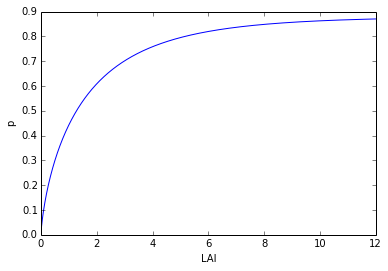

In [27]:
LAI = np.arange(0,12,0.01)
p = 0.88*(1 - np.exp(-0.7 * LAI**0.75))
plt.plot(LAI,p)
plt.xlabel('LAI')
plt.ylabel('p')

There are several ways we could estimate $p$. An interesting feature exploited by Knyazikhin et al. (2013) follows from:

$$
\frac{\rho}{\omega} = \frac{a}{1 - p \omega}
$$

so


$$
\frac{\rho}{\omega}  = a + p \rho
$$


So that if we plot $\frac{\rho}{\omega}$ as a function of $\rho$, this theory predicts we should see a straight line.

An example leaf single scattering albedo is given in [`files/data/ssalbedo.dat`](files/data/ssalbedo.dat):

(400.0, 2400.0)

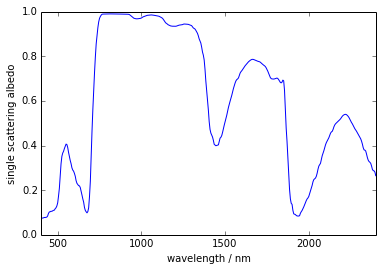

In [76]:
ssalbedo = np.loadtxt('files/data/ssalbedo.dat').T
plt.plot(ssalbedo[0],ssalbedo[1])
plt.xlabel('wavelength / nm')
plt.ylabel('single scattering albedo')
plt.xlim(ssalbedo[0][0],ssalbedo[0][-1])

which is sampled every 1 nm from 400 to 2400 nm.

We will clearly need to resample this to the same wavebands as the hyperspectral data:

In [77]:
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [78]:
f = interp1d(ssalbedo[0],ssalbedo[1])
omega = f(wavelength[wavelength<=2400])

The theory becomes more complicated when multiple absorbing constituents are involved, so we select here only wavelengths between 710 and 790 nm (on the 'red edge'), where the main absorbing constituent is chlorophyll.

In [83]:
# wavelength
W = (wavelength >= 710) & (wavelength <= 790)

wave = wavelength[W]
# single scattering albedo
omega = f(wavelength[W])
# reflectance
rho = hymap[W]

slope 0.710882123721 intercept 0.125383329915


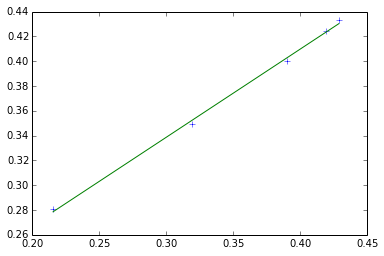

In [84]:
# lets see if its a straight line!
mean = rho.mean(axis=(1,2))
plt.plot(mean,mean/omega,'+')

# linear fit
slope, intercept, r_value, p_value, std_err = linregress(mean,mean/omega)
x = np.array([mean[0],mean[-1]])
plt.plot(x,x*slope+intercept)
print 'slope',slope,'intercept',intercept

So, here, $p$ is 0.71088

In [95]:
#p = 0.88*(1 - np.exp(-0.7 * LAI**0.75))
LAI = (np.log(1 - slope/0.88)/-0.7)**(4./3.)
print LAI

3.13529156174


Following Knyazikhin et al. (2013) we can calculate the `DASF` (Directional Area Scattering Function) from:

In [86]:
DASF = intercept/(1 - slope)
print DASF

0.43367546666


and from that, $W$:

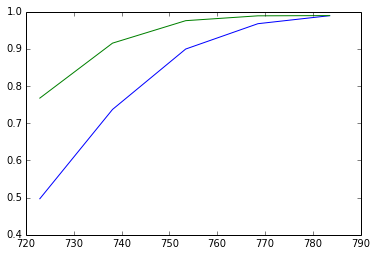

In [88]:
W = mean/DASF
plt.plot(wave,W)
plt.plot(wave,omega)

which in turn can give access to leaf biochemistry.

# The Task

The output of this exercise should be a spatial dataset of LAI.

The processing for this task is quite straightforward, and you *should* be able to develop a neat algorithm given the information above.

You should work in teams for this exercise as in previous weeks, and assign tasks for people to complete after you have discussed an overall algorithm and defined any interfaces you will need.

If you finish the task quickly, you could explore the impact of the the leaf single scattering albedo assumed, and/or examine the impact of widening the wavelength range used here. 